In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import itertools
from torch.utils.data import Dataset, DataLoader

In [3]:
from google.colab import drive
drive.mount('/content/drive')
import drive

Mounted at /content/drive


In [4]:
path_to_project = 'drive/My Drive/Colab Notebooks/Project'

In [5]:
demand_link_forth = np.load(f'{path_to_project}/Data/demand_link_forth.npy')
stops = np.load(f'{path_to_project}/Data/od_stop-202010-150.npy', allow_pickle=True)

In [6]:
# Define some Hyperparameters
input_dim = 9
hidden_dim = 30
n_layers = 3

seq_len = 72
batch_size=32

In [17]:
# Rearrange data from demand_link_forth according to hyperparameters
rnn_data = demand_link_forth
input_data = []
target_data = []
for i in range(0, len(rnn_data)-seq_len + 1):
  input_data.append(rnn_data[(i):(i+seq_len-1)])
  target_data.append(rnn_data[(i+1):(i+seq_len)])

input_data = torch.FloatTensor(input_data) 
target_data = torch.FloatTensor(target_data) 
print(f"input_data: {input_data.shape}, target_data: {target_data.shape}")

# Create dataset to use pytorchs splitting utilities
dataset = np.hstack((input_data, target_data))
len_dataset = dataset.shape[0]
len_val = int(len_dataset*0.1)
len_test = int(len_dataset*0.1)
len_train = len_dataset-len_val-len_test
print(f"len val: {len_val}, len test: {len_test}, len train: {len_train}")
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [len_train, len_val, len_test])

# Split each row of the dataset into input sequence and target sequence 
x_train = torch.Tensor(train_set)[:,:seq_len-1].cuda()
y_train = torch.Tensor(train_set)[:,seq_len-1:].cuda()
x_test = torch.Tensor(test_set)[:,:seq_len-1].cuda()
y_test = torch.Tensor(test_set)[:,seq_len-1:].cuda()
x_val = torch.Tensor(test_set)[:,:seq_len-1].cuda()
y_val = torch.Tensor(test_set)[:,seq_len-1:].cuda()
print(f"x_train: {x_train.shape}, y_train: {y_train.shape}")

input_data: torch.Size([5715, 71, 9]), target_data: torch.Size([5715, 71, 9])
len val: 571, len test: 571, len train: 4573
x_train: torch.Size([4573, 71, 9]), y_train: torch.Size([4573, 71, 9])


In [8]:
class TimeSeriesDataSet(Dataset):
  def __init__(self, X, Y):
    self.X = X
    self.Y = Y
    if len(self.X) != len(self.Y):
      raise Exception("The length of X does not match the length of Y")

  def __len__(self):
    return len(self.X)

  def __getitem__(self, index):
    # note that this isn't randomly selecting. It's a simple get a single item that represents an x and y
    _x = self.X[index]
    _y = self.Y[index]

    return _x, _y


# The Dataloader class handles all the shuffles for you
train_loader = DataLoader(TimeSeriesDataSet(x_train, y_train), batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(TimeSeriesDataSet(x_test, y_test), batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(TimeSeriesDataSet(x_val, y_val), batch_size=batch_size, shuffle=True, drop_last=True)

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # Recurrent layer
        self.lstm = nn.LSTM(input_size=input_dim,
                         hidden_size=hidden_dim,
                         num_layers=n_layers,
                         bidirectional=False,
                         batch_first=True)
        
        # Output layer
        self.l_out = nn.Linear(in_features=hidden_dim,
                            out_features=input_dim,
                            bias=False)
        
    def forward(self, x):
        # RNN returns output and last hidden state
        x, (h, c) = self.lstm(x)
        
        # Flatten output for feed-forward layer
        x = x.view(x.shape[0], -1, self.lstm.hidden_size)
        
        # Output layer
        x = self.l_out(x)
        
        return x

net = Net().cuda()
print(net)

Net(
  (lstm): LSTM(9, 30, num_layers=3, batch_first=True)
  (l_out): Linear(in_features=30, out_features=9, bias=False)
)


Epoch 0, training loss: 1056.0096435546875, validation loss: 1075.905517578125
Epoch 3, training loss: 737.780029296875, validation loss: 735.1434326171875
Epoch 6, training loss: 532.1871337890625, validation loss: 514.2098388671875
Epoch 9, training loss: 403.9860534667969, validation loss: 383.721435546875
Epoch 12, training loss: 313.9889831542969, validation loss: 291.6390380859375
Epoch 15, training loss: 252.9909210205078, validation loss: 229.5884246826172
Epoch 18, training loss: 209.09231567382812, validation loss: 189.02366638183594
Epoch 21, training loss: 175.20333862304688, validation loss: 154.46881103515625
Epoch 24, training loss: 149.11572265625, validation loss: 132.44146728515625
Epoch 27, training loss: 128.60987854003906, validation loss: 109.48847198486328
Epoch 30, training loss: 112.67130279541016, validation loss: 99.083984375
Epoch 33, training loss: 99.56085968017578, validation loss: 82.0126953125
Epoch 34, training loss: 95.77794647216797, validation loss:

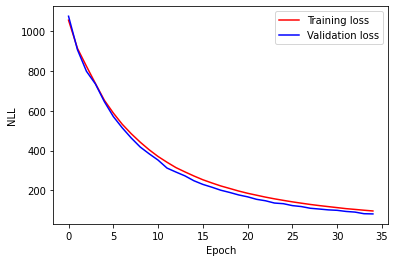

In [10]:
import torch.optim as optim
# Hyper-parameters
num_epochs = 35

batch_size = 32

# Initialize a new network
net = Net().cuda()

# Define a loss function and optimizer for this problem
criterion = nn.MSELoss() 
optimizer = optim.Adam(net.parameters(), lr=0.001) 

# Track loss
training_loss, validation_loss = [], []

# For each epoch
for i in range(num_epochs):
    
    # Track loss
    epoch_training_loss = 0
    epoch_validation_loss = 0
    
    # # For each sequence in validation set
    net.eval()
    # For each sentence in training set
    for inputs, targets in iter(val_loader):
        # Forward pass
        outputs = net(inputs)
        
        # Compute loss
        loss = criterion(outputs, targets)

        # Update loss
        epoch_validation_loss += loss.detach().cpu()

    net.train()
    # For each sequence in training set
    for inputs, targets in iter(train_loader):
        # Forward pass
        outputs = net(inputs)
        
        # Compute loss
        loss = criterion(outputs, targets)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update loss
        epoch_training_loss += loss.detach().cpu()
        
    # Save loss for plot
    training_loss.append(epoch_training_loss/len(train_loader))
    validation_loss.append(epoch_validation_loss/len(val_loader))

    # Print loss every 10 epochs
    if i % 3 == 0 or i == (num_epochs-1):
        print(f'Epoch {i}, training loss: {training_loss[-1]}, validation loss: {validation_loss[-1]}')

# Plot training and validation loss
epoch = np.arange(len(training_loss))
plt.figure()
plt.plot(epoch, training_loss, 'r', label='Training loss',)
plt.plot(epoch, validation_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('NLL')
plt.show()

Test Loss:  tensor(80.9359)


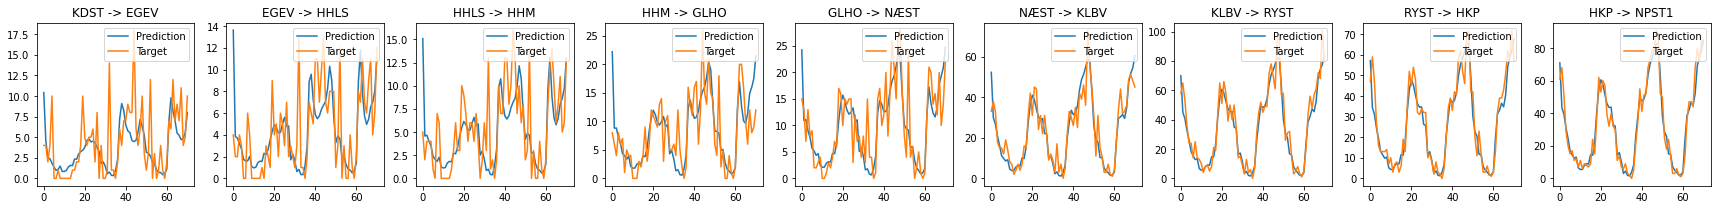

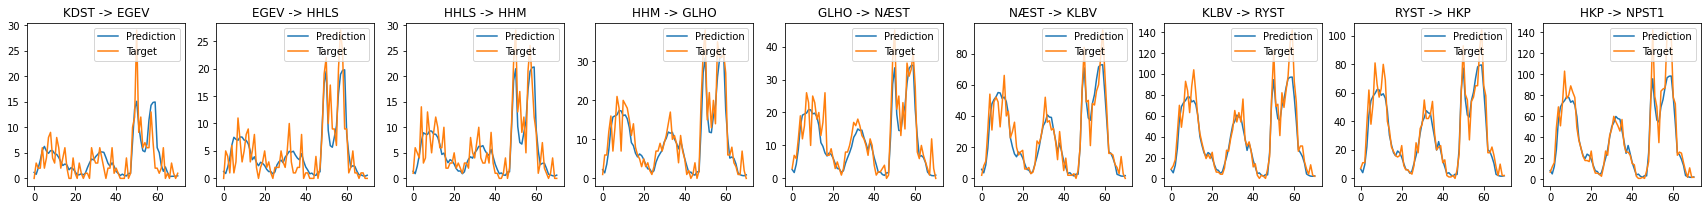

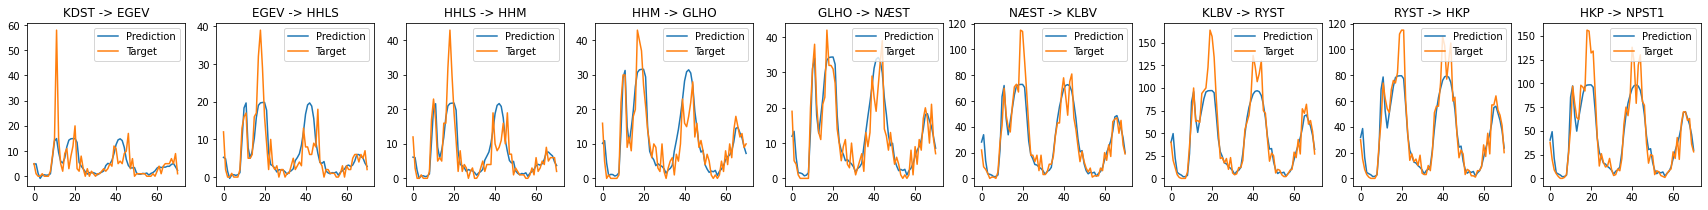

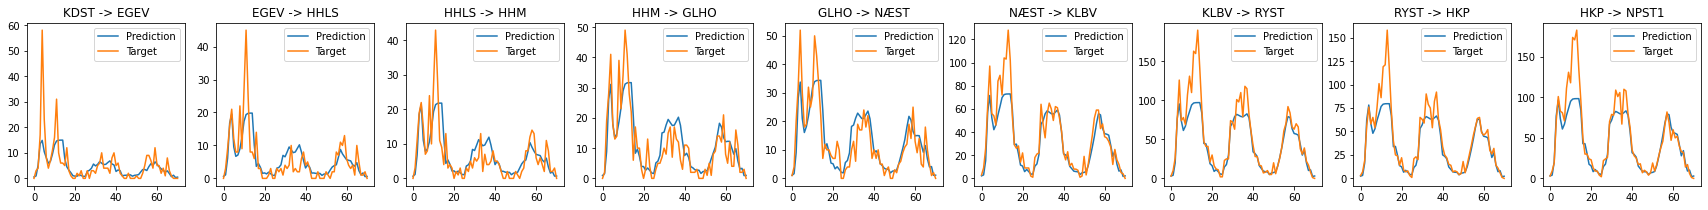

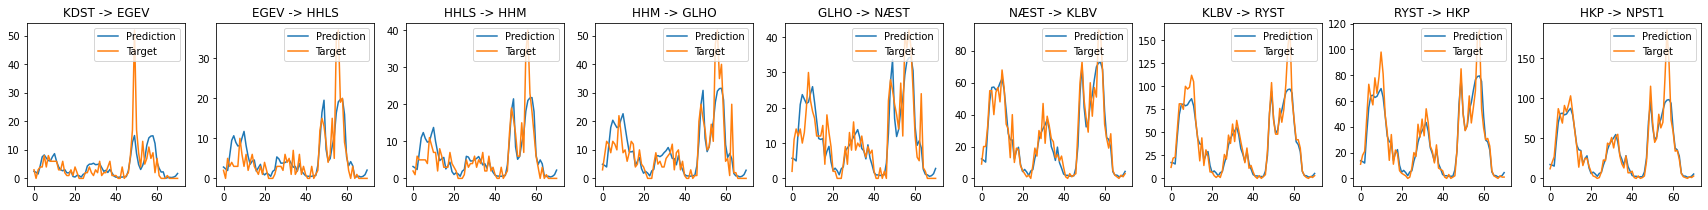

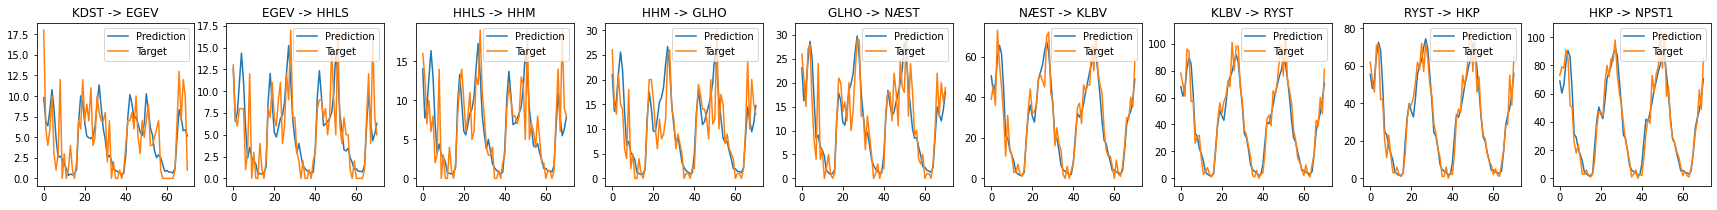

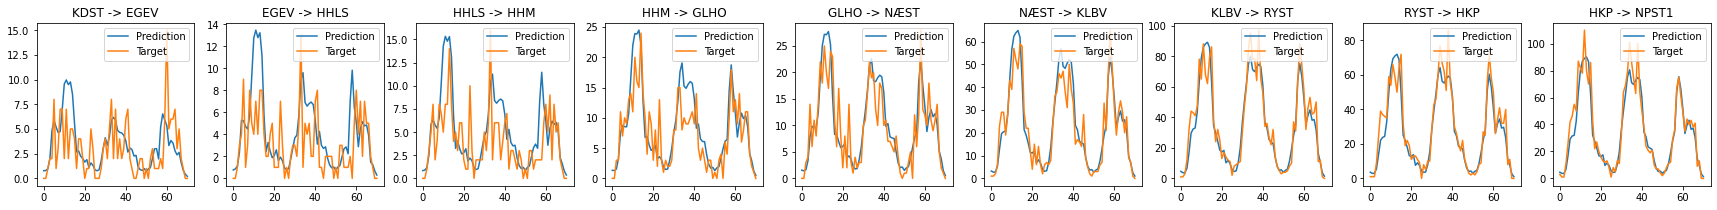

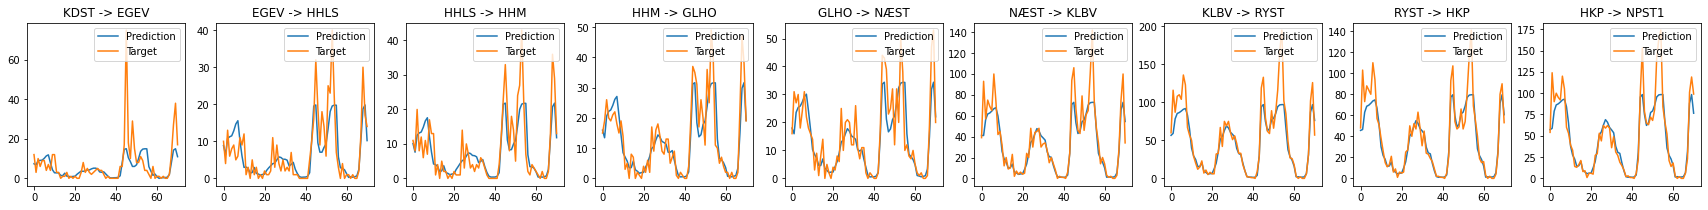

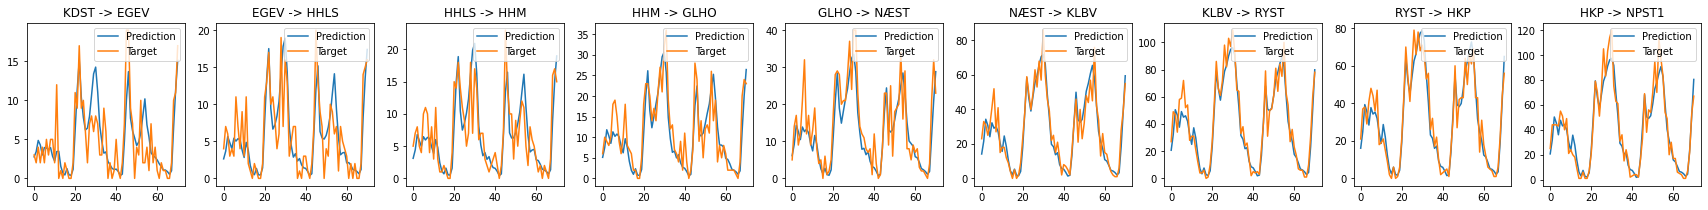

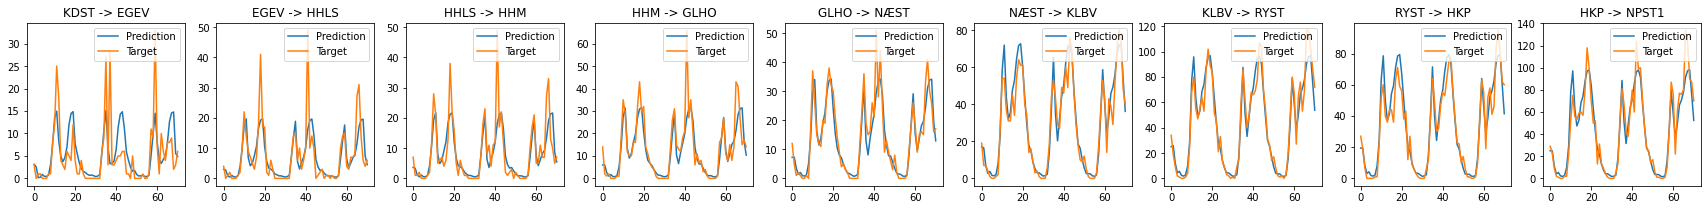

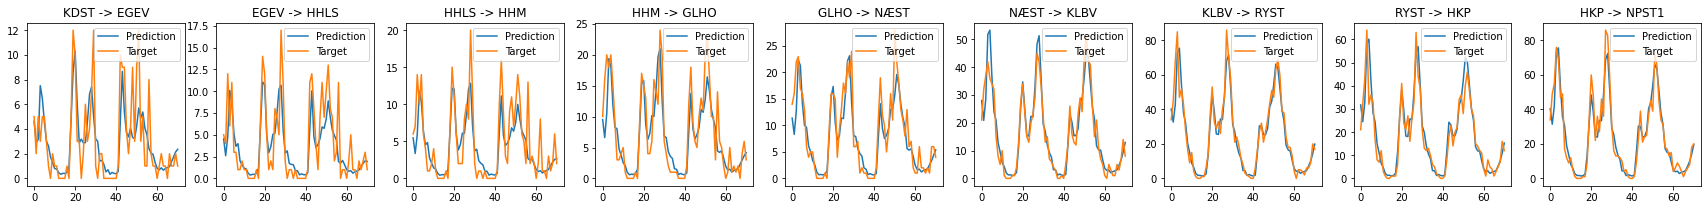

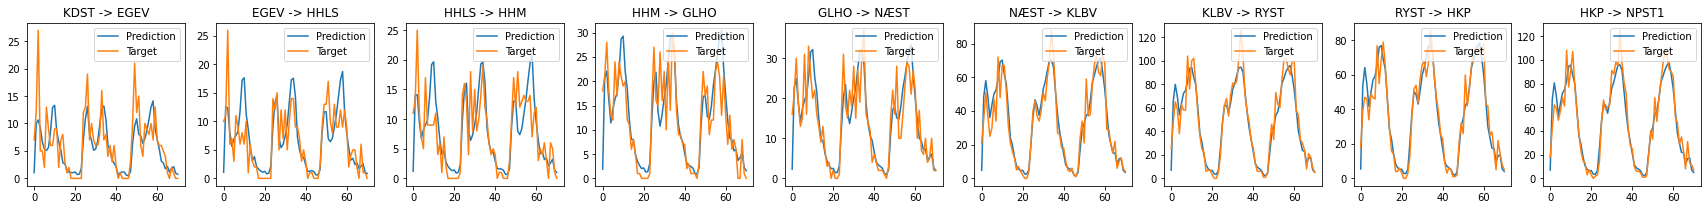

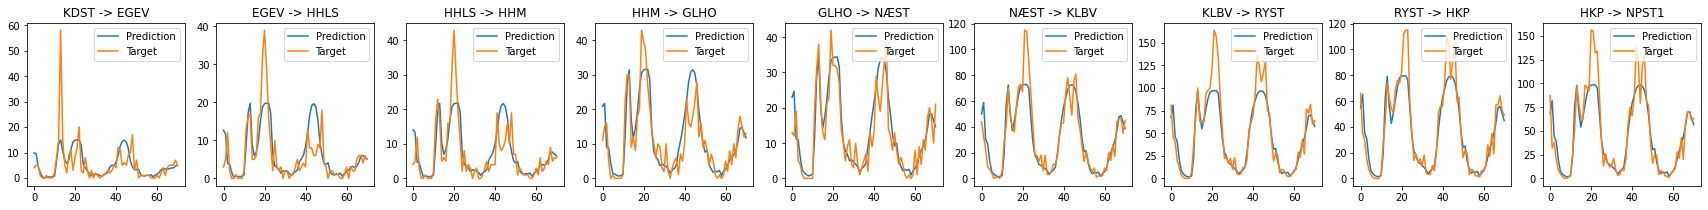

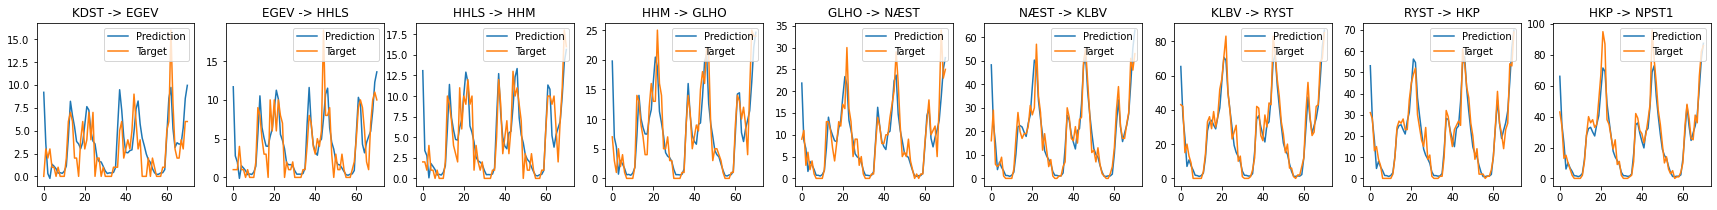

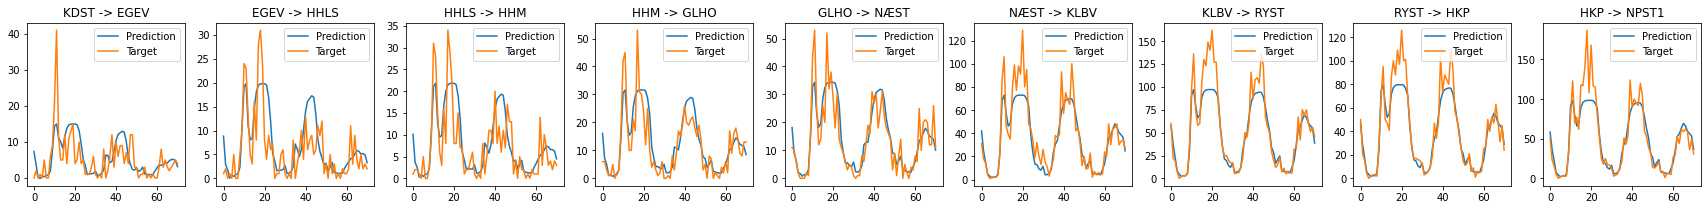

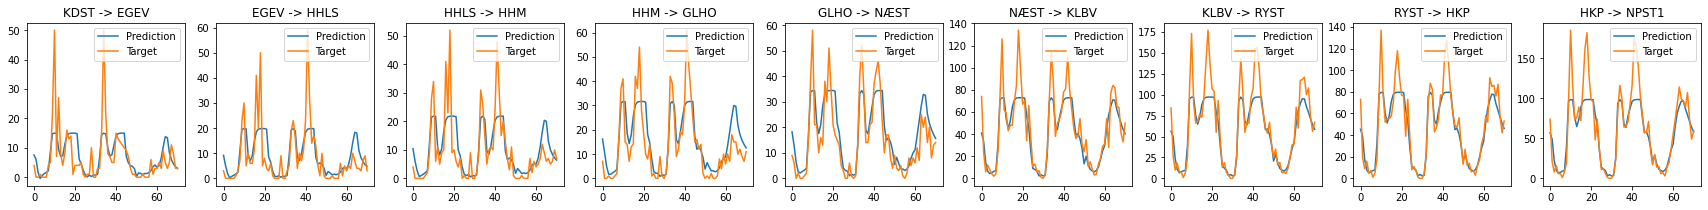

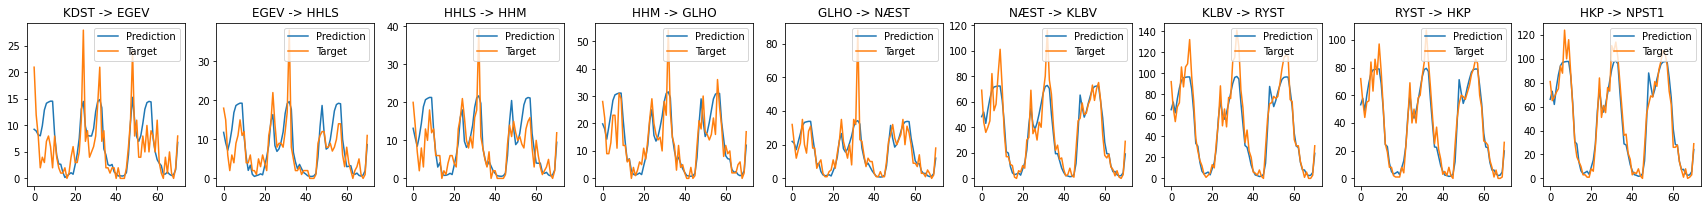

In [18]:
# test case
plotIDs = [1,100]


test_loss = 0

net.eval()
id = 0
for inputs, targets in iter(test_loader):
    id += 1
    # Forward pass
    outputs = net(inputs)
        
    # Compute loss
    loss = criterion(outputs, targets)

    # Update loss
    test_loss += loss.detach().cpu()    

    plt.figure(figsize=(30,3))

    for i in range(input_dim):
      stat_out = [x[i] for x in outputs[0]]
      stat_tar = [x[i] for x in targets[0]]

      plt.subplot(1, 9, i+1)
      plt.plot(stat_out)
      plt.plot(stat_tar)
      plt.title(stops[i] + " -> " + stops[i+1])
      plt.legend(["Prediction","Target"], loc='upper right')


print("Test Loss: ", (test_loss/len(test_loader)))

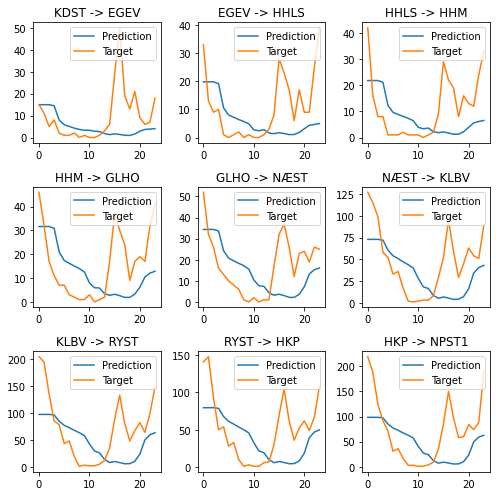

In [19]:
def predict(startID, iterations):
  inputs = torch.FloatTensor([rnn_data[(startID):(startID+seq_len-1)]]).cuda()
  targets = torch.FloatTensor(rnn_data[(startID+seq_len):(startID+seq_len+iterations)])
  results = []

  batch_size = 1

  for i in range(iterations):
    outputs = net(inputs)
    inputs = torch.cat((inputs[0][1:],outputs[0][-1:])).reshape(1,71,9)
    results.append(outputs[0][-1])

  plt.figure(figsize=(7,7))

  for i in range(input_dim):
    stat_out = [x[i] for x in results]
    stat_tar = [x[i] for x in targets]

    plt.subplot(3, 3, i+1)
    plt.plot(stat_out)
    plt.plot(stat_tar)
    plt.title(stops[i] + " -> " + stops[i+1])
    plt.legend(["Prediction","Target"], loc='upper right')

# predict(110, 24)
predict(160, 24)
# predict(270, 24)

plt.tight_layout()
plt.savefig(f'{path_to_project}/Plots/approach1.png',dpi=300)